Here we illustrate with a toy example the importance of balanced training

In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from face_lib.models.losses import ArcFaceLoss
from face_lib.models.arcface import MetricLearningModel
import seaborn as sns

In [2]:
# def get_data_loaders(subsets = None, batch_size=100, num_workers=10, shuffle=True):

#         train_loader = torch.utils.data.DataLoader(mnist_ds_train, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
#         test_loader = torch.utils.data.DataLoader(mnist_ds_test, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False)
#         return train_loader, test_loader

### 1. Train arcface on mnist

In [4]:
# 1. Define simple model
class Backbone(nn.Module):
    def __init__(self, num_features=128):
        super(Backbone, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(
            32,
            eps=1e-05,
        )
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(
            64,
            eps=1e-05,
        )
        self.features = nn.BatchNorm1d(num_features, eps=1e-05)
        self.fc1 = nn.Linear(9216, num_features)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.bn2(x)
        x = torch.flatten(x, 1)
        sig_x = x
        x = self.fc1(x)
        x = self.features(x)
        x = F.normalize(x, p=2.0, dim=1)
        output = {
            "feature": x,
            "bottleneck_feature": sig_x,
        }
        return output

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

mnist_ds_train = datasets.MNIST(
    root="/app/datasets/mnist", train=True, download=True, transform=transform
)
mnist_ds_test = datasets.MNIST(
    root="/app/datasets/mnist", train=False, download=True, transform=transform
)

In [5]:
NUM_FEATURES = 2

backbone_model = Backbone(num_features=NUM_FEATURES)
arcface_loss = ArcFaceLoss()

arcface_model = MetricLearningModel(
    backbone_model,
    arcface_loss,
    num_labels=10,
    train_set=mnist_ds_train,
    val_set=mnist_ds_test,
    num_features=NUM_FEATURES,
)

/home/erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(
/home/erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(


In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer

MAX_EPOCHS = 200

# use your own Comet parameters (need to register on https://www.comet.com) or disable the logger
# you can get api_key in the Quickstart guide section on the website
comet_logger = WandbLogger(
    # api_key="agnHNC2vEt7tOxnnxT4LzYf7Y",
    project="ArcFaceMnist",
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/app/outputs/arcface_mnist/ckpt/",
    filename="{epoch:02d}-{val_loss:.2f}",
)

# initialize trainer, use one GPU for training
trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    default_root_dir="/app/outputs/arcface_mnist",
    accelerator="gpu",
    devices=[0],
    benchmark=True,
    check_val_every_n_epoch=5,
    logger=comet_logger,
    callbacks=[checkpoint_callback],
)

# fit the model
trainer.fit(arcface_model);

100%|██████████| 79/79 [00:01<00:00, 49.36it/s]


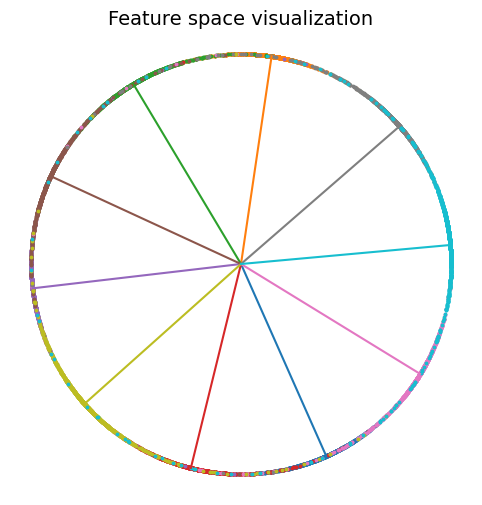

Average distance: 0.08820111341774464


In [7]:
from utils import predict_features, compute_distance_and_visualize

predicted_features, image_labels = predict_features(
    arcface_model, arcface_model.val_dataloader()
)

softmax_weights = arcface_model.softmax_weights.detach().cpu()
softmax_weights = F.normalize(softmax_weights, dim=1).numpy()

dists = compute_distance_and_visualize(
    predicted_features, image_labels, softmax_weights, num_features=NUM_FEATURES
)

print(f"Average distance: {np.mean(dists)}")

#### Cosine similarity distribution

In [10]:
# from torch.utils.data import DataLoader
# from utils import predict_features, compute_distance_and_visualize
# NUM_FEATURES = 2

# backbone_model = Backbone(num_features=NUM_FEATURES)
# arcface_loss = ArcFaceLoss()

# arcface_model = MetricLearningModel(
#     backbone_model,
#     arcface_loss,
#     num_labels=10,
#     train_set=mnist_ds_train,
#     val_set=mnist_ds_test,
#     num_features=NUM_FEATURES,
# )
# arcface_model = arcface_model.load_from_checkpoint('/app/outputs/arcface_mnist/ckpt/epoch=69-val_loss=1.21.ckpt')
# train_dl = DataLoader(
#             mnist_ds_train,
#             batch_size=128,
#             shuffle=False,
#             drop_last=False,
#             num_workers=32,
#         )
# test_dl = DataLoader(
#             mnist_ds_test,
#             batch_size=128,
#             shuffle=False,
#             drop_last=False,
#             num_workers=32,
#         )

# predicted_train_features, train_labels = predict_features(
#     arcface_model, train_dl
# )
# softmax_weights = F.normalize(arcface_model.softmax_weights, dim=1)
# wc = softmax_weights[train_labels, :].detach().cpu()
# predicted_train_features = torch.tensor(predicted_train_features)
# cosine_sim_train = torch.sum(predicted_train_features * wc, dim=1, keepdim=True)
# cosine_sim_train = cosine_sim_train[:, 0].numpy()
# np.save("mnist_train_cosine_sim.npy", cosine_sim_train)

# predicted_test_features, test_labels = predict_features(
#     arcface_model, test_dl
# )
# predicted_test_features = torch.tensor(predicted_test_features)
# wc_test = softmax_weights[test_labels, :].detach().cpu()
# cosine_sim_test = torch.sum(predicted_test_features * wc_test, dim=1, keepdim=True)
# cosine_sim_test = cosine_sim_test[:, 0].numpy()
# np.save("mnist_test_cosine_sim.npy", cosine_sim_test)

In [12]:
cosine_sim_train = np.load("mnist_train_cosine_sim.npy")
cosine_sim_test = np.load("mnist_test_cosine_sim.npy")
batch_size = 400
rng = np.random.default_rng(776)

/tmp/ipykernel_206933/1078766595.py:1: RuntimeWarning: invalid value encountered in arccos
  data = {"test": (np.arccos(cosine_sim_test) / (2 * np.pi))*360, 'train': (np.arccos(cosine_sim_train) / (2 * np.pi))*360}


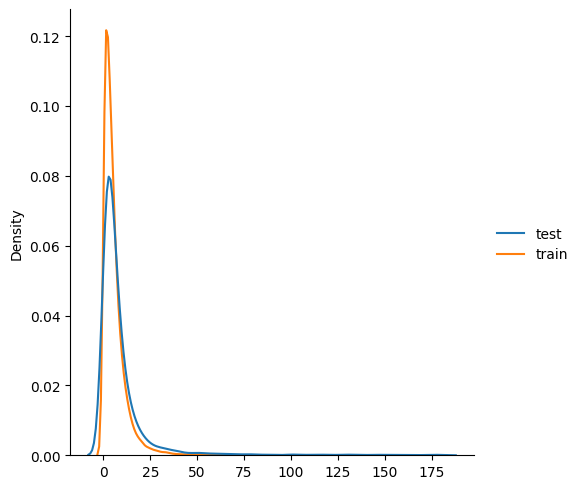

In [14]:
data = {
    "test": (np.arccos(cosine_sim_test) / (2 * np.pi)) * 360,
    "train": (np.arccos(cosine_sim_train) / (2 * np.pi)) * 360,
}
sns.displot(
    data,
    kind="kde",
    log_scale=False,
    common_norm=False,
)
# sns.displot(
#     ,
#     kind="kde",
#     log_scale=False,
#     common_norm=False,
# )

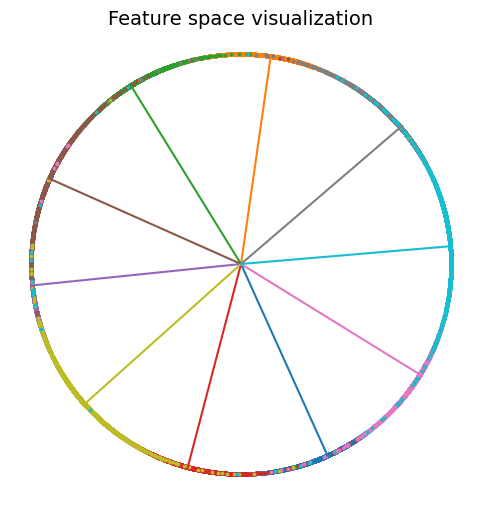

In [25]:
dists = compute_distance_and_visualize(
    predicted_train_features, train_labels, softmax_weights, num_features=NUM_FEATURES
)

### 2. Train scf model

/home/erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(
/home/erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
